In [1]:
from sklearn.preprocessing import MinMaxScaler , StandardScaler , QuantileTransformer , normalize
from lib.Model import Model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping , ModelCheckpoint
from keras import metrics, regularizers
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import datetime as dt
import csv
import re
from lib.DataProcess import Data

Using TensorFlow backend.


In [2]:
def load_chips(file):
    with open(file,'r',encoding='utf-8') as f:
        reader = csv.reader(f)
        chips = []
        for r in reader:
            r = np.array(r)
            if len(r) == 18:
                chips.append(r[[1,2,3,7,8,9,13,11,12,17]])
            if len(r) == 15:
                chips.append(r[[1,2,3,4,5,6,10,8,9,14]])
            if len(r) == 11:
                chips.append(r[1:])
    return chips
def minguo2Date(ming):
    y , m , d = ming.split('/')
    return str(int(y)+1911)+m+d

step = 20
units = 64
epochs = 500
batch_size = 256
stock_no = '2317'
model = Model()
model.add_saveinfo(stock=stock_no,exinfo=' steps-{}'.format(step))
early_stop = EarlyStopping(monitor='val_dense_1_loss', patience=20)
model_cp = ModelCheckpoint("save/{}.cp".format(dt.datetime.now().strftime('%Y-%m-%d_%H.%M')),monitor='val_dense_1_loss',save_best_only=True)

df = pd.read_csv('data/indicators/2317_indicators.csv')
df_chips = pd.DataFrame(load_chips('data/chips/chips_2317.csv'))
index=0
for i,d in enumerate(df.iloc[:,0].values):
    if minguo2Date(d) == '20120502':
        index = i
df = df[index:].reset_index(drop=True)
df = pd.concat([df,df_chips],axis=1)
df.drop(np.arange(33).tolist())

#get dates
dates = Data(0.8,np.array(df.get(['date']).values),type=2)
dates_train = dates.data_steps(dates.data_train,step)
dates_train_x , dates_train_y = dates.get_x_y(dates_train)
dates_val = dates.data_steps(dates.data_val,step)
dates_val_x , dates_val_y = dates.get_x_y(dates_val)

df = df.drop('date',axis=1)
mms = QuantileTransformer()
sc_data = mms.fit_transform(df.values)
x_trains= []
y_trains = []
x_vals = []
y_vals = []
historys = []
for i in range(sc_data.shape[1]):
    d = Data(0.8,sc_data[:,i],type=2)
    xt , yt = d.get_train(step,is_normalised=True,if_single_col=True)
    xv , yv = d.get_val(step,is_normalised=True,if_single_col=True)
    x_trains.append(xt[:,:,newaxis])
    y_trains.append(yt)
    x_vals.append(xv[:,:,newaxis])
    y_vals.append(yv)

In [ ]:
units = 64
model = Model()
for i in range(len(x_trains)):
    model.addIOLayer(Input(shape=(step-1,1)),Dense(1,activation='relu'))
model.addLayer(LSTM(units,activation='relu',kernel_regularizer = regularizers.l2(0.01),return_sequences=True))
model.addLayer(LSTM(units,kernel_regularizer = regularizers.l2(0.01),return_sequences=True))
model.addLayer(LSTM(units,kernel_regularizer = regularizers.l2(0.01),return_sequences=True))
model.addLayer(LSTM(units,kernel_regularizer = regularizers.l2(0.01),return_sequences=False))
model.build_model(loss='mean_squared_error',optimizer='Adam')
model.model.summary()

In [ ]:
#model.train(x_trains,y_trains,x_vals,y_vals,epochs,batch_size,shuffle=False,callbacks=[early_stop,model_cp])
train_gen = Data.generate_train_batch(x_trains,y_trains,batch_size=batch_size,is_multi_windows=True)
train_steps_per_epoch = math.ceil((np.array(x_trains).shape[1] - step) / batch_size)
val_gen = Data.generate_train_batch(x_vals,y_vals,batch_size=batch_size,is_multi_windows=True)
val_steps_per_epoch = math.ceil((np.array(x_vals).shape[1] - step) / batch_size)
model.train_generator(train_gen,train_steps_per_epoch,val_gen,val_steps_per_epoch,epochs,callbacks=[early_stop,model_cp])

In [ ]:
historys.extend(model.history.history['val_dense_1_loss'])
plt.plot(historys,label='closed_loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig(model.save_path+'.png',dpi=200)
plt.show()

In [3]:
model = Model(load='save/V4 2019-10-15_03.53steps-20.h5')
#model.model.summary()
#from keras.utils import plot_model
#plot_model(model.model, to_file='model.png')

In [4]:
preds = model.predict_recurrent(x_vals,20,True)
ps = model.model.predict(x_vals)

Figure saved [2019-10-17_04.41.png].


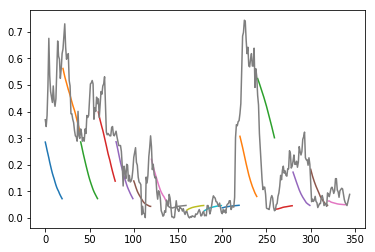

In [5]:
model.plot_recurrent_results(preds,y_vals,20,multi_io=True,show_legend=False,target_index=0,save=True)

Average Errors: 0.015766688096433817


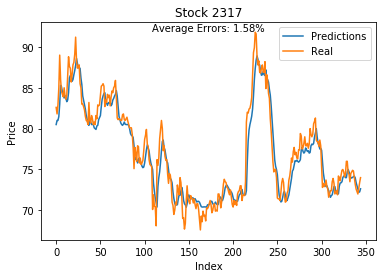

In [6]:
in_x_vals = mms.inverse_transform(np.array(x_vals)[:,:,-1,0].T)
in_ps = mms.inverse_transform(np.array(ps)[:,:,0].T)
in_preds = mms.inverse_transform(np.array(preds)[:,-1,:,0])
in_y_vals = mms.inverse_transform(np.array(y_vals)[:,:,0].T)

pre_closed = in_ps[:,0]
#origin x prices
x_closed = in_x_vals[:,0]
true_closed = in_y_vals[:,0]
#the last day of each window
dates_step_last = dates_val_x[:,-1,0]
true_step_closed = []
pre_step_closed = []
x_step_closed = []
dates_x_step = []
dates_y_step = []
for i in range(0,int(len(x_closed)/step)):
    x_step_closed.append(x_closed[i*step])
    dates_x_step.append(dates_step_last[i*step])
    true_step_closed.append(true_closed[(i+1)*step-1])
    pre_step_closed.append(pre_closed[(i+1)*step-1])
    dates_y_step.append(dates_val_y[(i+1)*step-1,0])

avg_error = np.mean(np.abs(pre_closed-true_closed)/true_closed)
print("Average Errors:",avg_error)

plt.plot(in_ps[:,0],label='Predictions')
plt.plot(in_y_vals[:,0],label='Real')
plt.title('Stock '+stock_no)
plt.xlabel('Index')
plt.ylabel('Price')
plt.text(plt.xlim()[1]*0.3,plt.ylim()[1]*0.988,'Average Errors: {:0.2f}%'.format(avg_error*100))
plt.legend(loc='best')
plt.savefig('save/figs/avg_error/{}.png'.format(model.save_path[5:]),dpi=200)
plt.show()

In [22]:
#sr: spread rate
def ROR(prices,preds,real,init_funds,period=12,sr=0.000,short=False):
    dict_Info = {
        'total_costs':[],
        'total_prices':[],
        'trade_times':[],
        'verbose':[],
        "RORs":[]
    }
    funds = init_funds
    profit=0
    total_cost=0
    total_price=0
    acc = []
    times = 0
    verbose = ''
    for i,p in enumerate(real):
        if preds[i]>prices[i] and (abs(preds[i]-prices[i])/prices[i]) > sr:
            times +=1
            quantity = int(funds / prices[i])
            total_cost += prices[i] * quantity
            total_price += p * quantity
            funds += (p-prices[i]) * quantity
            verbose += "\nBought Date: {} - {}\nSold Date: {} - {}\nPrediction: {}\nProfit Spread: {}\n".format(dates_x_step[i],prices[i],dates_y_step[i],p,preds[i],p-prices[i])
        elif short:
            times +=1
            quantity = int(funds / prices[i])
            total_price += prices[i] * quantity
            total_cost += p * quantity
            funds += (prices[i]-p) * quantity
            verbose += "\nShort Date: {} - {}\nBought Date: {} - {}\nPrediction: {}\nProfit Spread: {}\n".format(dates_x_step[i],prices[i],dates_y_step[i],p,preds[i],prices[i]-p)
        if (i+1)%period==0:
            #pass and not record the rate of prediciotn 'pre' < rate of threshold 'r'
            if total_cost != 0:
                dict_Info['total_costs'].append(total_cost*1000)
                dict_Info['total_prices'].append(total_price*1000)
                dict_Info['trade_times'].append(times)
                dict_Info['verbose'].append(verbose)
                dict_Info['RORs'].append((funds)/init_funds)
            times=0
            funds = init_funds
            total_cost=0
            total_price=0
            verbose = ''
    if times!=0:
        dict_Info['total_costs'].append(total_cost*1000)
        dict_Info['total_prices'].append(total_price*1000)
        dict_Info['trade_times'].append(times)
        dict_Info['verbose'].append(verbose)
        #exclude 0.00425%. including tax and trading fee
        dict_Info['RORs'].append((funds)/init_funds*0.99575)
    return dict_Info,init_funds

In [20]:
d,funds = ROR(x_step_closed,in_preds[:,0],true_step_closed,1000,short=True)
for i in range(len(d['total_prices'])):
    msg = 'Year {}\nTotal Costs: {}\nInitial Funds: {}\nTrade Times:{}\nProfits: {}\nReturn Of Rate: {}\n'.format(i+1,d['total_costs'][i],
                                                                                    funds*1000,
                                                                                    d['trade_times'][i],
                                                                                     (d['total_prices'][i]-d['total_costs'][i])*0.99575,
                                                                                     d['RORs'][i])
    print(d['verbose'][i])
    print(msg)
print("Average of Yearly ROR: {:.3f}".format(np.mean(d['RORs'])))


Short Date: 107/05/07 - 81.6
Bought Date: 107/06/04 - 87.8
Prediction: 73.35725402832031
Profit Spread: -6.200000000000003

Short Date: 107/06/04 - 87.8
Bought Date: 107/07/03 - 80.7
Prediction: 81.36109161376953
Profit Spread: 7.099999999999994

Short Date: 107/07/03 - 80.7
Bought Date: 107/07/31 - 83.8
Prediction: 73.37841033935547
Profit Spread: -3.0999999999999943

Short Date: 107/07/31 - 83.8
Bought Date: 107/08/28 - 81.2
Prediction: 75.80000305175781
Profit Spread: 2.5999999999999943

Short Date: 107/08/28 - 81.2
Bought Date: 107/09/26 - 77.3
Prediction: 73.37291717529297
Profit Spread: 3.9000000000000057

Short Date: 107/09/26 - 77.3
Bought Date: 107/11/02 - 81.0
Prediction: 71.9000015258789
Profit Spread: -3.700000000000003

Short Date: 107/11/02 - 81.0
Bought Date: 107/11/30 - 71.9
Prediction: 72.4000015258789
Profit Spread: 9.099999999999994

Bought Date: 107/11/30 - 71.9
Sold Date: 107/12/27 - 70.8
Prediction: 72.0
Profit Spread: -1.1000000000000085

Bought Date: 107/12/27 

In [19]:
d,funds = ROR(x_step_closed,in_preds[:,0],true_step_closed,1000,short=False)
for i in range(len(d['total_prices'])):
    msg = 'Year {}\nTotal Costs: {}\nInitial Funds: {}\nTrade Times:{}\nProfits: {}\nReturn Of Rate: {}\n'.format(i+1,d['total_costs'][i],
                                                                                    funds*1000,
                                                                                    d['trade_times'][i],
                                                                                     (d['total_prices'][i]-d['total_costs'][i])*0.99575,
                                                                                     d['RORs'][i])
    print(d['verbose'][i])
    print(msg)
print("Average of Yearly ROR: {:.3f}".format(np.mean(d['RORs'])))


Bought Date: 107/11/30 - 71.9
Sold Date: 107/12/27 - 70.8
Prediction: 72.0
Profit Spread: -1.1000000000000085

Bought Date: 107/12/27 - 70.8
Sold Date: 108/01/28 - 70.8
Prediction: 72.0
Profit Spread: 0.0

Bought Date: 108/01/28 - 70.8
Sold Date: 108/03/08 - 70.7
Prediction: 72.0
Profit Spread: -0.09999999999999432

Bought Date: 108/03/08 - 70.7
Sold Date: 108/04/09 - 82.5
Prediction: 72.0
Profit Spread: 11.799999999999997

Year 1
Total Costs: 3694600.0
Initial Funds: 1000000
Trade Times:4
Profits: 137214.35
Return Of Rate: 1.1378


Bought Date: 108/06/05 - 71.0
Sold Date: 108/07/04 - 77.7
Prediction: 72.0
Profit Spread: 6.700000000000003

Year 2
Total Costs: 994000.0
Initial Funds: 1000000
Trade Times:1
Profits: 93401.35
Return Of Rate: 1.0891513499999999

Average of Yearly ROR: 1.113


In [24]:
right = []
for i in range(len(x_step_closed)):
    a = 0
    b = 0
    if x_step_closed[i] < in_preds[:,0][i]:
        a = 1
    if x_step_closed[i] < true_step_closed[i]:
        b = 1
    if a==b:
        right.append(1)
    else:
        right.append(0)
print(np.mean(right))

0.5294117647058824
